# Uso de filtros espaciales y morfológicos

## RafaCastle

## Resumen

Este notebook detecta los logotipos de marcas conocidas en una imágen, por ejemplo nike, adidas o puma.

Este notebook se divide en 2 secciones:

 - Código funcional: Este es el código comentado a grandes rasgos, es el programa con el cual se obtienen los resultados finales de este trabajo.
 - Explicación del código: En esta sección se explicará el funcionamiento del código y no es necesario correrla para el funcionamiento del mismo, sin embargo se recomienda su revisión para entender mejor el funcionamiento del código. 


# Sección 1: Código Funcional

Importando librerías

In [ ]:
# en caso de no tener la librería OpenCV instalada
!pip install opencv-python

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

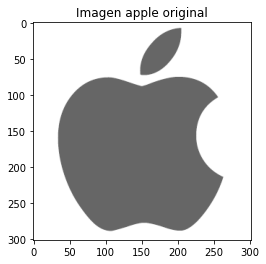

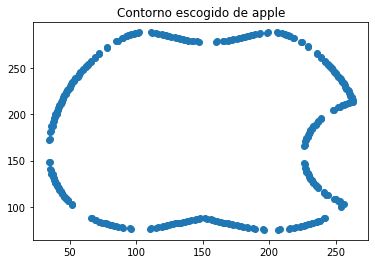

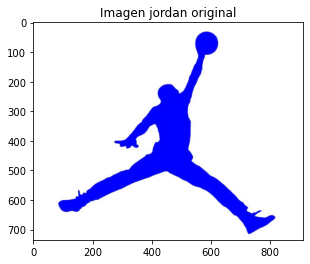

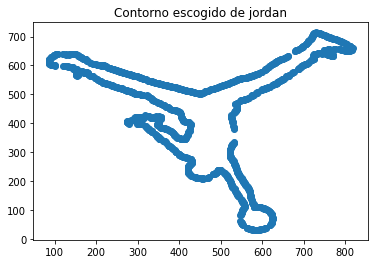

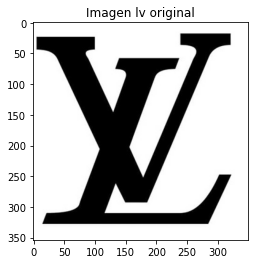

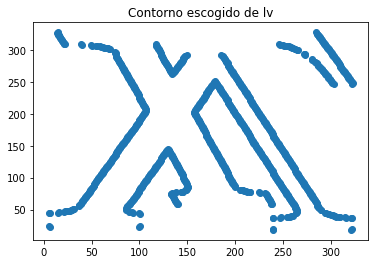

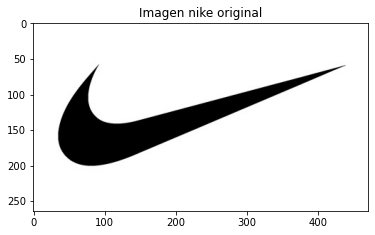

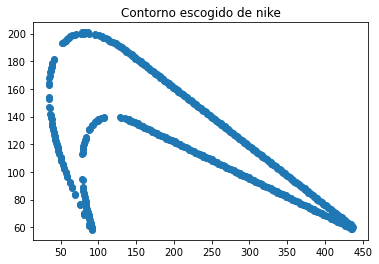

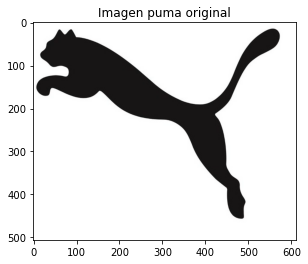

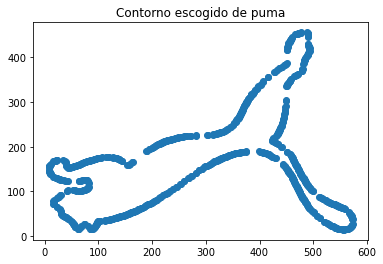

In [2]:
# importando las imágenes
apple = cv2.imread('apple.png')
jordan = cv2.imread('jordan.jpg')
lv = cv2.imread('lv.jpg')
nike = cv2.imread('nike.jpg')
puma = cv2.imread('puma.jpg')

imagenes = {'apple':[apple],
            'jordan':[jordan],
            'lv':[lv],
            'nike':[nike],
            'puma':[puma]}

# se mostrarán los contornos de las imágenes
for imagen in imagenes:

    #  convirtiendo a escala de grises
    escala_grises = cv2.cvtColor(imagenes[imagen][0], cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(escala_grises, 127, 255, cv2.THRESH_BINARY)

    # hallando contornos
    contornos, _ = cv2.findContours(
        threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # calculando la cantidad de puntos en un contorno
    largo_contornos = [len(i) for i in contornos[1:]]
    
    # contorno con más puntos
    maximo = max(largo_contornos)
    indice_max = largo_contornos.index(maximo)
    
    # rectángulo más chiquito que contiene a la figura
    rectangulo_minimo = [None]*len(contornos)

    # se obtendran las medidas de la imagen y se graficarán sus contornos
    for i,contorno in enumerate(contornos[1:]):

        # coordenadas de los contornos
        contorno_x=[]
        contorno_y=[]
        
        # tomando solo el contorno más grande
        if i==indice_max:
            
            # guardando las coordenadas
            for coordenadas in contorno:
                contorno_x.append(coordenadas[0][0])
                contorno_y.append(coordenadas[0][1])
                
            # mostrando la imagen original
            plt.imshow(imagenes[imagen][0])
            plt.title(f'Imagen {imagen} original')
            plt.show()

            # mostrando el contorno de la imagen
            plt.scatter(x=contorno_x, y=contorno_y)
            plt.title(f'Contorno escogido de {imagen}')
            plt.show()    
            
            # calculando el rectángulo mínimo
            rectangulo_minimo[i] = cv2.minAreaRect(contorno)
            
            # coordenadas de las esquinas del rectángulo
            caja = np.intp(cv2.boxPoints(rectangulo_minimo[i]))
            
            # longitudes del rectángulo
            l1 = math.dist(caja[0],caja[1])
            l2 = math.dist(caja[1],caja[2])
            l3 = math.dist(caja[2],caja[3])
            l4 = math.dist(caja[3],caja[0])
            longitudes=[l1,l2,l3,l4]
            
            # base
            lmax = max(longitudes)
            
            # altura
            lmin = min(longitudes)
            
            # se guarda el contorno y el factor f
            imagenes[imagen].append(contorno)
    imagenes[imagen].append(lmax/lmin)

Este es el primer filtro que se creó, si bien hace buenas detecciones para imágenes donde las marcas están bien delimitadas, tiene problemas para fotografías o imágenes más complicadas, se pondran unos ejemplos a continuación.

In [3]:
# se define la función con la imagen y el valor epsilon
def filtro1(img,eps):

    # se muestra la imagen original
    plt.imshow(img)
    plt.title('Imagen original')
    plt.show()

    #  convirtiendo a escala de grises
    escala_grises = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(escala_grises, 127, 255, cv2.THRESH_BINARY)
    
    # hallando contornos
    contornos, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    cajas = {}
    
    # calculando el rectángulo mínimo
    rectangulo_minimo = [None]*len(contornos)
    color = (0, 0, 255)
    
    # Se detectarán los contornos en la imagen
    for i, c in enumerate(contornos):
        
        # coordenadas de las esquinas del rectángulo
        rectangulo_minimo[i] = cv2.minAreaRect(c)
        cajas[i] = np.intp(cv2.boxPoints(rectangulo_minimo[i]))

        # se trazará el rectángulo mínimo a la imagen (opcional)
#        cv2.drawContours(img, [cajas[i]], 0, color)
        
    # se grafica la imagen con los rectángulos calculados (opcional)
#    plt.imshow(img)
#    plt.title('Deteccion de rectángulos')
#    plt.show()

    # se calcularan las medidas de la imagen
    sub_imagenes={}
    for i, c in enumerate(contornos):
        
        # longitudes
        l1 = math.dist(cajas[i][0],cajas[i][1])
        l2 = math.dist(cajas[i][1],cajas[i][2])
        l3 = math.dist(cajas[i][2],cajas[i][3])
        l4 = math.dist(cajas[i][3],cajas[i][0])
        longitudes=[l1,l2,l3,l4]
        
        # base
        lmax = max(longitudes)
        
        # altura
        lmin = min(longitudes)
        
        # para prevenir errores
        if lmin==0:
            lmax=0
            lmin=1
            
        # se guarda el factor f
        sub_imagenes[i]=lmax/lmin

        # filtro
        for imagen in imagenes:
            if lmax/lmin >= imagenes[imagen][2]*(1-eps) and lmax/lmin <= imagenes[imagen][2]*(1+eps):
                
                # se detecta el centro del contorno
                M = cv2.moments(c)
                x=0
                y=0
                if M['m00'] != 0.0:
                    x = int(M['m10']/M['m00'])
                    y = int(M['m01']/M['m00'])
                    
                # se coloca la etiqueta en el centro del contorno
                cv2.putText(img, imagen, (x, y),cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), 2)
                
    # se grafica la imagen con las detecciones
    plt.imshow(img)
    plt.title('Deteccion  de figuras')
    plt.show()

Buena respuesta en imágenes bien delimitadas

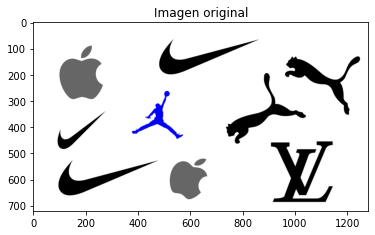

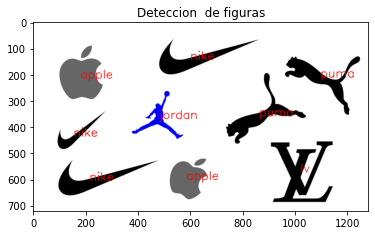

In [4]:
filtro1(cv2.imread('imagen.png'),0.02)

Respuesta imprecisa en imágenes complicadas

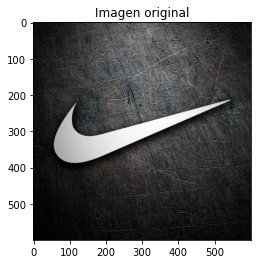

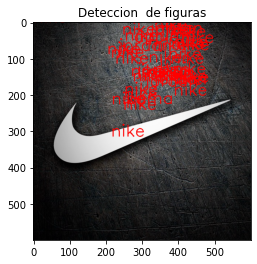

In [5]:
filtro1(cv2.imread('nike1.jpg'),0.02)

El segundo filtro resuelve este error, haciendo detecciones en imágenes más complicadas, como se mostrará a continuación.

In [6]:
# se define la función con la imagen y el valor epsilon
def filtro2(img,eps,mat):

    # se muestra la imagen original
    plt.imshow(img)
    plt.title('Imagen original')
    plt.show()

    #  convirtiendo a escala de grises
    escala_grises = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(escala_grises, 127, 255, cv2.THRESH_BINARY)
    
    # hallando contornos
    contornos, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    cajas = {}
    
    # calculando el rectángulo mínimo
    rectangulo_minimo = [None]*len(contornos)
    color = (0, 0, 255)
    
    # Se detectarán los contornos en la imagen
    for i, c in enumerate(contornos):
        
        # coordenadas de las esquinas del rectángulo
        rectangulo_minimo[i] = cv2.minAreaRect(c)
        cajas[i] = np.intp(cv2.boxPoints(rectangulo_minimo[i]))

        # se trazará el rectángulo mínimo a la imagen (opcional)
#        cv2.drawContours(img, [cajas[i]], 0, color)
        
    # se grafica la imagen con los rectángulos calculados (opcional)
#    plt.imshow(img)
#    plt.title('Deteccion de rectángulos')
#    plt.show()

    # se calcularan las medidas de la imagen
    sub_imagenes={}
    for i, c in enumerate(contornos):
        
        # longitudes
        l1 = math.dist(cajas[i][0],cajas[i][1])
        l2 = math.dist(cajas[i][1],cajas[i][2])
        l3 = math.dist(cajas[i][2],cajas[i][3])
        l4 = math.dist(cajas[i][3],cajas[i][0])
        longitudes=[l1,l2,l3,l4]
        
        # base
        lmax = max(longitudes)
        
        # altura
        lmin = min(longitudes)
        
        # para prevenir errores
        if lmin==0:
            lmax=0
            lmin=1
            
        # se guarda el factor f
        sub_imagenes[i]=lmax/lmin

        # filtro
        for imagen in imagenes:
            
            # coincidencia entre las imágenes
            match = cv2.matchShapes(imagenes[imagen][1],c,1,0.0)

            # filtro
            if lmax/lmin >= imagenes[imagen][2]*(1-eps) and lmax/lmin <= imagenes[imagen][2]*(1+eps) and match<mat:
                
                # se detecta el centro del contorno
                M = cv2.moments(c)
                x=0
                y=0
                if M['m00'] != 0.0:
                    x = int(M['m10']/M['m00'])
                    y = int(M['m01']/M['m00'])
                    
                # se coloca la etiqueta en el centro del contorno
                cv2.putText(img, imagen, (x, y),cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), 2)
                
    # se grafica la imagen con las detecciones
    plt.imshow(img)
    plt.title('Deteccion  de figuras')
    plt.show()

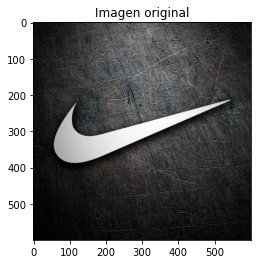

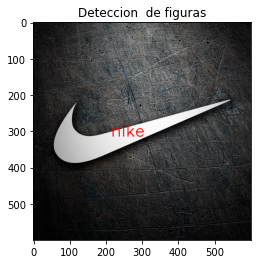

In [7]:
filtro2(cv2.imread('nike1.jpg'),0.02,0.9)

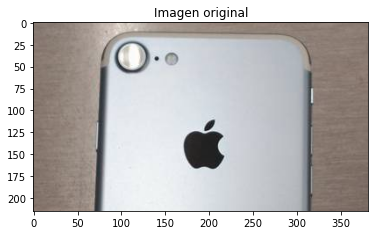

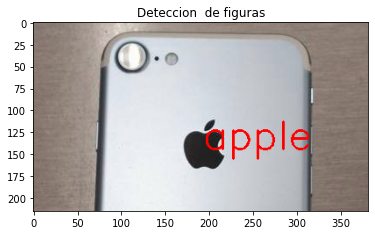

In [8]:
filtro2(cv2.imread('apple1.jpg'),0.01,0.01)

Los resultados han sido más que satisfactorios!

# Sección 2: Explicación del código

Una imagen pude constar de un contorno único, sin embargo, es posible que una imagen tenga varios contornos, tomemos el siguiente ejemplo. En la siguiente celda se muestra el logo de Apple y es notorio que al detectar los contornos se detectan 2 diferentes, uno corresponde a la manzana mordida y el otro a la hoja que está sibre la manzana:

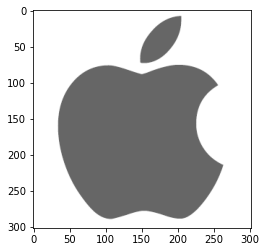

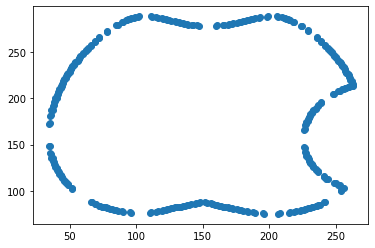

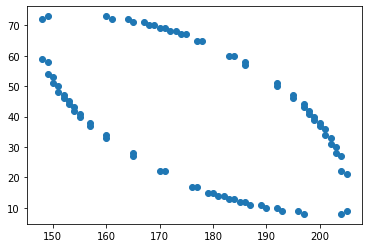

In [106]:
apple = cv2.imread('apple.png')

escala_grises = cv2.cvtColor(apple, cv2.COLOR_BGR2GRAY)
_, threshold = cv2.threshold(escala_grises, 127, 255, cv2.THRESH_BINARY)

# hallando contornos
contornos, _ = cv2.findContours(
    threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

plt.imshow(apple)
plt.show()

for i,contorno in enumerate(contornos[1:]):

    contorno_x=[]
    contorno_y=[]

    for coordenadas in contorno:
        contorno_x.append(coordenadas[0][0])
        contorno_y.append(coordenadas[0][1])

    plt.scatter(x=contorno_x, y=contorno_y)
    plt.show()    
            

Por simplicidad, en este filtro nos interesa solamente analizar uno de los contornos, el código escoge el contorno que contiene más puntos (daremos por hecho que ese es el contorno más representativo de la imágen), en este caso, el código se queda con el contorno de la manzana mordida:

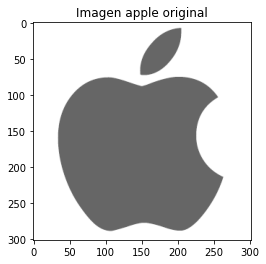

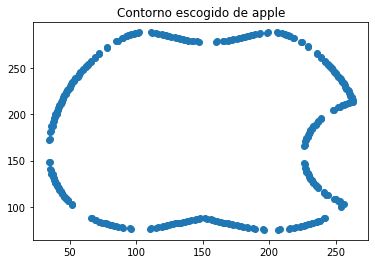

In [5]:
# importando la imagen
apple = cv2.imread('apple.png')

imagenes = {'apple':[apple]}

# se mostrarán los contornos de la imagen
for imagen in imagenes:

    #  convirtiendo a escala de grises
    escala_grises = cv2.cvtColor(imagenes[imagen][0], cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(escala_grises, 127, 255, cv2.THRESH_BINARY)

    # hallando contornos
    contornos, _ = cv2.findContours(
        threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # calculando la cantidad de puntos en un contorno
    largo_contornos = [len(i) for i in contornos[1:]]

    # contorno con más puntos
    maximo = max(largo_contornos)
    indice_max = largo_contornos.index(maximo)

    # se obtendran las medidas de la imagen y se graficarán sus contornos
    for i,contorno in enumerate(contornos[1:]):

        # coordenadas de los contornos
        contorno_x=[]
        contorno_y=[]
        
        # tomando solo el contorno más grande
        if i==indice_max:
            
            # guardando las coordenadas
            for coordenadas in contorno:
                contorno_x.append(coordenadas[0][0])
                contorno_y.append(coordenadas[0][1])
                
            # mostrando la imagen original
            plt.imshow(imagenes[imagen][0])
            plt.title(f'Imagen {imagen} original')
            plt.show()

            # mostrando el contorno de la imagen
            plt.scatter(x=contorno_x, y=contorno_y)
            plt.title(f'Contorno escogido de {imagen}')
            plt.show()    

Por lo tanto el código buscará un contorno que se parezca al que seleccionó para detectar las marcas. 

Veamos ahora como funciona el primer filtro, el programa va a detectar los rectángulos más pequeños que contengan a los contornos que detecte en una imagen. Veamos el siguiente ejemplo:

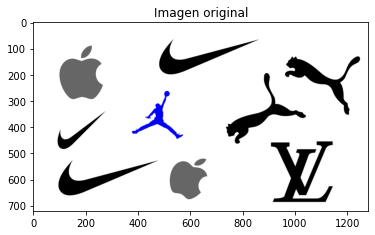

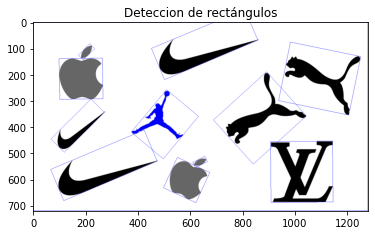

In [6]:
img = cv2.imread('imagen.png')

# se muestra la imagen original
plt.imshow(img)
plt.title('Imagen original')
plt.show()

#  convirtiendo a escala de grises
escala_grises = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, threshold = cv2.threshold(escala_grises, 127, 255, cv2.THRESH_BINARY)

# hallando contornos
contornos, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cajas = {}

# calculando el rectángulo mínimo
rectangulo_minimo = [None]*len(contornos)
color = (0, 0, 255)

# Se detectarán los contornos en la imagen
for i, c in enumerate(contornos):

    # coordenadas de las esquinas del rectángulo
    rectangulo_minimo[i] = cv2.minAreaRect(c)
    cajas[i] = np.intp(cv2.boxPoints(rectangulo_minimo[i]))

    # se trazará el rectángulo mínimo a la imagen
    cv2.drawContours(img, [cajas[i]], 0, color)

# se grafica la imagen con los rectángulos calculados
plt.imshow(img)
plt.title('Deteccion de rectángulos')
plt.show()

Aquí, el código ha derectado los rectángulos más chicos que contienen el logo de una imágen. En la primera parte del código, se guararon las medidas de los rectángulos de cada una de las marcas, es decir, su base y su altura. Así, cada una de las figuras puede ser identificada por el factor $f = base/altura$. A continuación se muestra el valor del factor $f$ para las distintas marcas:

 - apple: 1.065
 - jordan: 1.322
 - lv: 1.023
 - nike: 3.023
 - puma: 1.20
 
 En general el factor $f$ es único para cada una de éstas, en una primera prueba veremos como funciona el filtro al decir que una imágen con factor $f_1$ es igual que una con factor $f_2$ si $f_1 \in (f_2(1-\epsilon),f_2(1+\epsilon))$. Donde el valor de $\epsilon$ queda como una variable abierta, en este caso lo escogeremos igual a 0.02:

In [ ]:
1.065 (1.07(0.98),1.07(1.02))

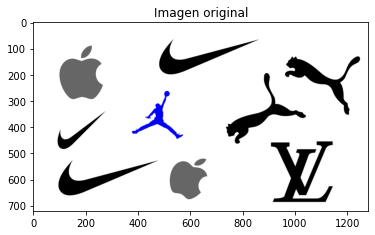

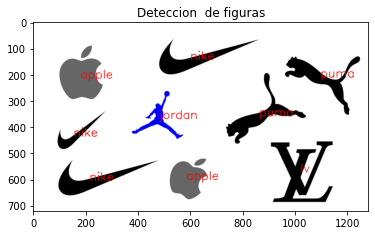

In [12]:
filtro1(cv2.imread('imagen.png'),0.02)

Sin embargo, este mismo funcionamiento no nos sirve para imágenes un poco más complejas, en el siguiente ejemplo vemos como se detectan distintos elementos en la imagen que no nos son de utilidad:

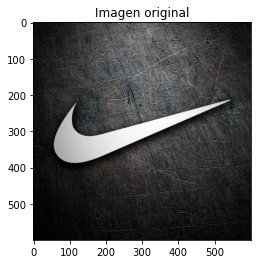

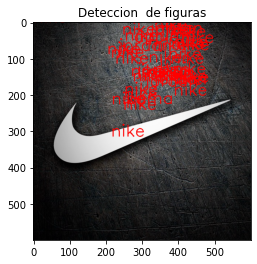

In [16]:
filtro1(cv2.imread('nike1.jpg'),0.02)

Podría parecer intuitivo que al bajar el valor de $\epsilon$ se detecte la imágen buscada, sin embargo esto no es así, probemos con $\epsilon = 0.01$

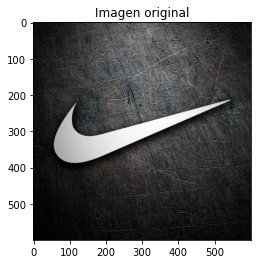

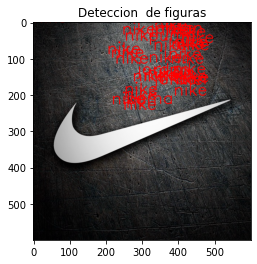

In [17]:
filtro1(cv2.imread('nike1.jpg'),0.01)

Vemos que ahora no se detecta la imagen deseada, es por eso que se acude a un segundo filtro, este filtro utilizará la función cv2.match. Dicha función compara 2 contornos diferentes y regresa un valor que denominaremos $m$ que es más pequeño mientras más parecidos sean los contornos. Es decir, si se comparan 2 contornos exactamente iguales el valor será 0, si son parecidos el valor puede ser 0.3 y si son muy diferentes el valor podría ser 3.9 o mayor. 

El código del segundo filtro calcula el valor $m$ y lo toma como consideración, en conjunto con el factor $f$ para detectar si 2 contornos son parecidos. La condición que agrega el filtro 2 es que el valor $m$ debe ser menor a un cierto valor $M$ dado. 

Veamos los resultados de este filtro para $\epsilon = 0.02$ y $m = 0.9$

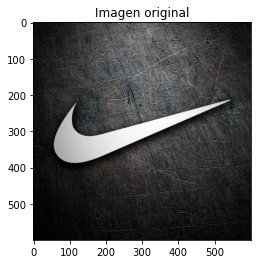

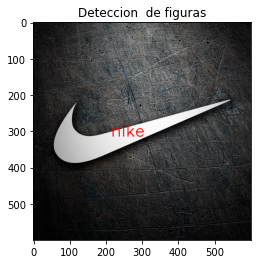

In [18]:
filtro2(cv2.imread('nike1.jpg'),0.02,0.9)

Ahora el filtro detectó el elemento deseado sin problemas. Podría parecer que con el nuevo factor $m$ ya no es necesario hacer el análisis de rectángulos, sin embargo, es posible que el factor $m$ por si solo no pueda hacer detecciones acertadas, veamos el siguiente ejemplo donde cambiar el valor $m$ no genera una buena detección. Tomemos primero $m=0.01$, el código detecta más de lo que necesitamos:

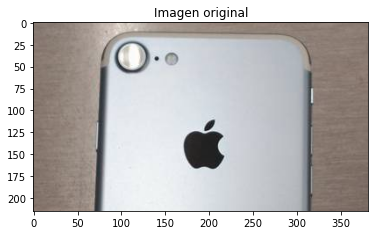

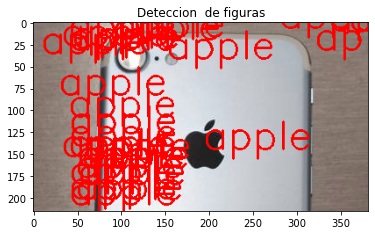

In [20]:
filtro2(cv2.imread('apple1.jpg'),0.1,0.01)

Bajemos entonces el valor del factor $m$ y veamos si la detección mejora:

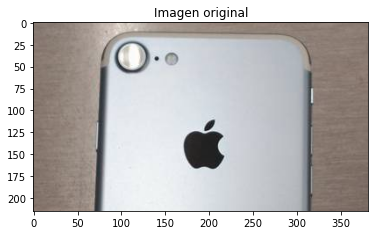

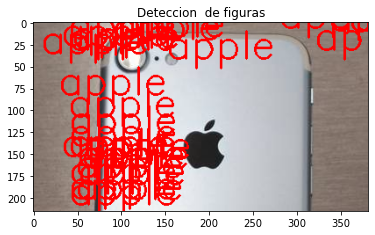

In [29]:
filtro2(cv2.imread('apple1.jpg'),0.1,0.001)

Ahora se ha perdido la detección que buscabamos, regresemos el valor de $m$ a 0.01 y ahora cambiemos el valor de $f$ a 0.05:

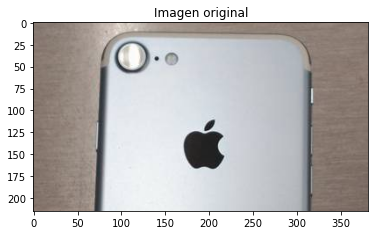

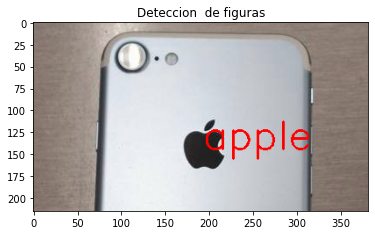

In [30]:
filtro2(cv2.imread('apple1.jpg'),0.05,0.01)

Ahora tenemos la detección que buscábamos, de esta forma es claro que tener ambos filtros resulta útil para la detección de marcas y se propondría, para trabajos futuros, utilizar estos filtros para entrenar redes neuronales y hallar los mejores valores de $f$ y $m$ dado el logo de una marca.